In [1]:
from xbbg import blp
import xlwings as xlw
import pandas as pd
import datetime as dt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
sht = xlw.Book(r'C:\Users\PZAPOLSKY\DataScience\GLR\GLRtoendMarch2021.xlsx').sheets[0]

In [3]:
df = sht.range('A1:U233').options(pd.DataFrame).value

In [4]:
df.Stock = [ df.Stock[i].upper() for i in range(df.shape[0]) ]

In [5]:
proxy = []
for i in range(df.shape[0]):
    try:
        proxy.append(blp.bdh(tickers=(df.Stock.iloc[i] + ' Equity'), start_date=(str(df.Date.iloc[i]).split('-')[0]+str(df.Date.iloc[i]).split('-')[1]+str(df.Date.iloc[i]).split('-')[2]).split(' ')[0], 
    end_date=(str(df.Date.iloc[i]).split('-')[0]+str(df.Date.iloc[i]).split('-')[1]+str(df.Date.iloc[i]).split('-')[2]).split(' ')[0])[blp.bdh(tickers=(df.Stock.iloc[i] + ' Equity'), start_date=(str(df.Date.iloc[i]).split('-')[0]+str(df.Date.iloc[i]).split('-')[1]+str(df.Date.iloc[i]).split('-')[2]).split(' ')[0], 
    end_date=(str(df.Date.iloc[i]).split('-')[0]+str(df.Date.iloc[i]).split('-')[1]+str(df.Date.iloc[i]).split('-')[2]).split(' ')[0]).columns[0][0]].Last_Price[0])
    except:
        proxy.append(0)
    
df['proxy'] = proxy
df['checking'] = df['Client PX'] / df['proxy']
df = df.drop(df[df['checking'] < 0.05].index)

In [7]:
df['crncy'] = [ blp.bdp(df.Stock.iloc[i] + ' Equity', 'CRNCY')[blp.bdp(df.Stock.iloc[i] + ' Equity', 'CRNCY').columns[0]].iloc[0] for i in range(df.shape[0]) ] 

In [22]:
glr = pd.DataFrame()
bads = []
for i in range(160, df.shape[0]):
    print(i)
    #next month
    next_month = blp.bdh(tickers=(df.Stock.iloc[i] + ' Equity'), start_date=(str(df.Date.iloc[i]).split('-')[0]+str(df.Date.iloc[i]).split('-')[1]+str(df.Date.iloc[i]).split('-')[2]).split(' ')[0], 
        end_date=(str(df.Date.iloc[i] + dt.timedelta(days=30)).split('-')[0]+str(df.Date.iloc[i] + dt.timedelta(days=30)).split('-')[1]+str(df.Date.iloc[i] + dt.timedelta(days=30)).split('-')[2]).split(' ')[0]) 

    try:
        next_month = next_month[next_month.columns[0][0]]
    except:
        bads.append(i)
        continue
        
    #today
    day = blp.bdib((df.Stock.iloc[i] + ' Equity'), dt=(str(df.Date.iloc[i]).split('-')[0]+str(df.Date.iloc[i]).split('-')[1]+str(df.Date.iloc[i]).split('-')[2]).split(' ')[0], session='day')
    day = day[day.columns[0][0]]
    day.index = [day.index[j].tz_localize(None) for j in range(day.shape[0]) ] 

    trade_time = dt.datetime(df.iloc[i]['Date'].year, df.iloc[i]['Date'].month, df.iloc[i]['Date'].day, int(df.Time.iloc[i].split(':')[0]), int(df.Time.iloc[i].split(':')[1]), int(df.Time.iloc[i].split(':')[2]))
    if 'LI' in df.iloc[i]['Stock']:
        trade_time = trade_time - dt.timedelta(hours=3)

    day = day[day.index > trade_time]   
    day['price'] = (day['open'] + day['close'] + day['high'] + day['low'])/4
    
    #today auc
    day_auc_p = blp.bdh((df.Stock.iloc[i] + ' Equity'), 'OFFICIAL_CLOSE_AUCTION_PRICE', (str(df.Date.iloc[i]).split('-')[0]+str(df.Date.iloc[i]).split('-')[1]+str(df.Date.iloc[i]).split('-')[2]).split(' ')[0], 
                      (str(df.Date.iloc[i]).split('-')[0]+str(df.Date.iloc[i]).split('-')[1]+str(df.Date.iloc[i]).split('-')[2]).split(' ')[0] )
    try:
        day_auc_p = day_auc_p[day_auc_p.columns[0][0]].iloc[0][0]
    except:
        bads.append(i)
        continue
    day_auc_v = blp.bdh((df.Stock.iloc[i] + ' Equity'), 'OFFICIAL_CLOSE_AUCTION_VOLUME', (str(df.Date.iloc[i]).split('-')[0]+str(df.Date.iloc[i]).split('-')[1]+str(df.Date.iloc[i]).split('-')[2]).split(' ')[0], 
                      (str(df.Date.iloc[i]).split('-')[0]+str(df.Date.iloc[i]).split('-')[1]+str(df.Date.iloc[i]).split('-')[2]).split(' ')[0] )    
    day_auc_v = day_auc_v[day_auc_v.columns[0][0]].iloc[0][0]
    #tom
    step = 1
    if df.Date.iloc[i].weekday() == 4:
        step += 2
    tom = blp.bdib((df.Stock.iloc[i] + ' Equity'), dt=(str(df.Date.iloc[i] + dt.timedelta(days=step)).split('-')[0]+str(df.Date.iloc[i] + dt.timedelta(days=step)).split('-')[1]+str(df.Date.iloc[i] + dt.timedelta(days=step)).split('-')[2]).split(' ')[0], session='day')
    try:
        tom = tom[tom.columns[0][0]]
    except:
        bads.append(i)
        continue
    tom.index = [tom.index[j].tz_localize(None) for j in range(tom.shape[0]) ] 
 
    tom['price'] = (tom['open'] + tom['close'] + tom['high'] + tom['low'])/4

    #tom auc
    tom_auc_p = blp.bdh((df.Stock.iloc[i] + ' Equity'), 'OFFICIAL_CLOSE_AUCTION_PRICE', (str(df.Date.iloc[i] + dt.timedelta(days=step)).split('-')[0]+str(df.Date.iloc[i] + dt.timedelta(days=step)).split('-')[1]+str(df.Date.iloc[i] + dt.timedelta(days=step)).split('-')[2]).split(' ')[0], 
                      (str(df.Date.iloc[i] + dt.timedelta(days=step)).split('-')[0]+str(df.Date.iloc[i] + dt.timedelta(days=step)).split('-')[1]+str(df.Date.iloc[i] + dt.timedelta(days=step)).split('-')[2]).split(' ')[0] )
    
    try:
        tom_auc_p = tom_auc_p[tom_auc_p.columns[0][0]].iloc[0][0]
    except IndexError:
        tom_auc_p = day_auc_p
    
    tom_auc_v = blp.bdh((df.Stock.iloc[i] + ' Equity'), 'OFFICIAL_CLOSE_AUCTION_VOLUME', (str(df.Date.iloc[i] + dt.timedelta(days=step)).split('-')[0]+str(df.Date.iloc[i] + dt.timedelta(days=step)).split('-')[1]+str(df.Date.iloc[i] + dt.timedelta(days=step)).split('-')[2]).split(' ')[0], 
                      (str(df.Date.iloc[i] + dt.timedelta(days=step)).split('-')[0]+str(df.Date.iloc[i] + dt.timedelta(days=step)).split('-')[1]+str(df.Date.iloc[i] + dt.timedelta(days=step)).split('-')[2]).split(' ')[0] )    
    try:
        tom_auc_v = tom_auc_v[tom_auc_v.columns[0][0]].iloc[0][0]
    except IndexError:
        tom_auc_v = 0    
    # our position
    if df['Quantity'].iloc[i] > 0:
        our_pos = 'short'
        day_better = day[day.price < df['Client PX'].iloc[i]]
        tom_better = tom[tom.price < df['Client PX'].iloc[i]]
    else:
        our_pos = 'long'
        day_better = day[day.price > df['Client PX'].iloc[i]]
        tom_better = tom[tom.price > df['Client PX'].iloc[i]]
        
    ex = {}

    ### 1. today limit for win
    if day_better.shape[0] == 0:
        v_better = 0
    else:
        p_better = day_better.price.mean()
        v_better = day_better.volume.sum()/2

        if (v_better / p_better) < abs(df.iloc[i]['Quantity']):
            if (v_better / p_better) < abs(df.iloc[i]['Quantity'])/2:
                v_better = 1
            else:
                v_better = 0

    if (v_better ==0) | (v_better ==1):
        if v_better == 1:
            ex['1/2 tod limit'] = p_better
            ex['tod limit'] = 0
        else:
            ex['1/2 tod limit'] = 0
            ex['tod limit'] = 0
    else:
        ex['tod limit'] = p_better
    
    ### 2. tommorow limit
    if tom_better.shape[0] == 0:
        v_better = 0
    else:
        p_better = tom_better.price.mean()
        v_better = tom_better.volume.sum()/2

        if (v_better / p_better) < abs(df.iloc[i]['Quantity']):
            if (v_better / p_better) < abs(df.iloc[i]['Quantity'])/2:
                v_better = 1
            else:
                v_better = 0
                
    if (v_better ==0) | (v_better ==1):
        if v_better == 1:
            ex['1/2 tom limit'] = p_better
            ex['tom limit'] = 0
        else:
            ex['1/2 tom limit'] = 0
            ex['tom limit'] = 0
    else:
        ex['tom limit'] = p_better

    
    ### participation 
    days2 = day.append(tom)
    days2['25%'] = days2.volume.cumsum()/4
    days2['20%'] = days2.volume.cumsum()/5
    days2['15%'] = days2.volume.cumsum()/6.5
    days2['10%'] = days2.volume.cumsum()/9
    days2['5%'] = days2.volume.cumsum()/20
    
    ex['25%'] = days2[days2['25%'] < abs(df.Quantity.iloc[i]) ].price.mean()
    ex['20%'] = days2[days2['20%'] < abs(df.Quantity.iloc[i]) ].price.mean()
    ex['15%'] = days2[days2['15%'] < abs(df.Quantity.iloc[i]) ].price.mean()
    ex['10%'] = days2[days2['10%'] < abs(df.Quantity.iloc[i]) ].price.mean()
    ex['5%'] = days2[days2['5%'] < abs(df.Quantity.iloc[i]) ].price.mean()
    
    ### vwap 
    ex['vwap tod+tom'] = (days2.volume * days2.price).sum()/(days2.volume.sum())
    try:
        ex['vwap tom'] = (days2.loc[day.index[-1]::].volume * days2.loc[day.index[-1]::].price).sum()/(days2.loc[day.index[-1]::].volume.sum())
    except:
        ex['vwap tod'] = ex['vwap tod+tom']    
    try:    
        ex['vwap tod'] = (day.volume * day.price).sum()/(day.volume.sum())
    except:
        ex['vwap tod'] = ex['vwap tod+tom']
        
    ### auc
    ex['tod auc'] = day_auc_p
    ex['tom auc'] = tom_auc_p
    
    if df['Quantity'].iloc[i] > 0:
        try:
            ex['hold7'] = next_month.iloc[0:5][next_month.iloc[0:5].Last_Price < df['Client PX'].iloc[i]].Last_Price[0]
        except:
            ex['hold7'] = next_month.iloc[0:5].Last_Price[-1]
                                               
        try:
            ex['hold14'] = next_month.iloc[0:12][next_month.iloc[0:12].Last_Price < df['Client PX'].iloc[i]].Last_Price[0]
        except:
            ex['hold14'] = next_month.iloc[0:12].Last_Price[-1]       
        try:
            ex['hold28'] = next_month.iloc[0:25][next_month.iloc[0:25].Last_Price < df['Client PX'].iloc[i]].Last_Price[0]
        except:
            ex['hold28'] = next_month.iloc[0:25].Last_Price[-1]
    else:
        try:
            ex['hold7'] = next_month.iloc[0:5][next_month.iloc[0:5].Last_Price > df['Client PX'].iloc[i]].Last_Price[0]
        except:
            ex['hold7'] = next_month.iloc[0:5].Last_Price[-1]                                               
        try:
            ex['hold14'] = next_month.iloc[0:12][next_month.iloc[0:12].Last_Price > df['Client PX'].iloc[i]].Last_Price[0]
        except:
            ex['hold14'] = next_month.iloc[0:12].Last_Price[-1]       
        try:
            ex['hold28'] = next_month.iloc[0:25][next_month.iloc[0:25].Last_Price > df['Client PX'].iloc[i]].Last_Price[0]
        except:
            ex['hold28'] = next_month.iloc[0:25].Last_Price[-1]

    
    ### 0. 10 limits
    next_month = next_month.iloc[0:14]

    if our_pos == 'short':
        if next_month[next_month.Last_Price < df['Client PX'].iloc[i]*0.99].shape[0] == 0:
            ex['14limit0.01'] = next_month[-3::].mean().Last_Price
        else:
            ex['14limit0.01'] = next_month[next_month.Last_Price < df['Client PX'].iloc[i]*0.99].Last_Price[0]
    else:
        if next_month[next_month.Last_Price > df['Client PX'].iloc[i]*1.01].shape[0] == 0:
            ex['14limit0.01'] = next_month[-3::].mean().Last_Price
        else:
            ex['14limit0.01'] = next_month[next_month.Last_Price > df['Client PX'].iloc[i]*1.01].Last_Price[0]        
########################
    if our_pos == 'short':
        if next_month[next_month.Last_Price < df['Client PX'].iloc[i]].shape[0] == 0:
            ex['14limit0'] = next_month[-3::].mean().Last_Price
        else:
            ex['14limit0'] = df['Client PX'].iloc[i]
    else:
        if next_month[next_month.Last_Price > df['Client PX'].iloc[i]].shape[0] == 0:
            ex['14limit0'] = next_month[-3::].mean().Last_Price
        else:
            ex['14limit0'] = df['Client PX'].iloc[i]
########################            
    if our_pos == 'short':
        if next_month[next_month.Last_Price < df['Client PX'].iloc[i]*0.98].shape[0] == 0:
            ex['14limit0.02'] = next_month[-3::].mean().Last_Price
        else:
            ex['14limit0.02'] = next_month[next_month.Last_Price < df['Client PX'].iloc[i]*0.98].Last_Price[0]
    else:
        if next_month[next_month.Last_Price > df['Client PX'].iloc[i]*1.02].shape[0] == 0:
            ex['14limit0.02'] = next_month[-3::].mean().Last_Price
        else:
            ex['14limit0.02'] = next_month[next_month.Last_Price > df['Client PX'].iloc[i]*1.02].Last_Price[0] 
########################
    if our_pos == 'short':
        if next_month[next_month.Last_Price < df['Client PX'].iloc[i]*0.97].shape[0] == 0:
            ex['14limit0.03'] = next_month[-3::].mean().Last_Price
        else:
            ex['14limit0.03'] = next_month[next_month.Last_Price < df['Client PX'].iloc[i]*0.97].Last_Price[0]
    else:
        if next_month[next_month.Last_Price > df['Client PX'].iloc[i]*1.03].shape[0] == 0:
            ex['14limit0.03'] = next_month[-3::].mean().Last_Price
        else:
            ex['14limit0.03'] = next_month[next_month.Last_Price > df['Client PX'].iloc[i]*1.03].Last_Price[0]   


        
    ### 0. 10 limits
    next_month = next_month.iloc[0:7]

    if our_pos == 'short':
        if next_month[next_month.Last_Price < df['Client PX'].iloc[i]*0.99].shape[0] == 0:
            ex['7limit0.01'] = next_month[-3::].mean().Last_Price
        else:
            ex['7limit0.01'] = next_month[next_month.Last_Price < df['Client PX'].iloc[i]*0.99].Last_Price[0]
    else:
        if next_month[next_month.Last_Price > df['Client PX'].iloc[i]*1.01].shape[0] == 0:
            ex['7limit0.01'] = next_month[-3::].mean().Last_Price
        else:
            ex['7limit0.01'] = next_month[next_month.Last_Price > df['Client PX'].iloc[i]*1.01].Last_Price[0]        
########################
    if our_pos == 'short':
        if next_month[next_month.Last_Price < df['Client PX'].iloc[i]].shape[0] == 0:
            ex['7limit0'] = next_month[-3::].mean().Last_Price
        else:
            ex['7limit0'] = df['Client PX'].iloc[i]
    else:
        if next_month[next_month.Last_Price > df['Client PX'].iloc[i]].shape[0] == 0:
            ex['7limit0'] = next_month[-3::].mean().Last_Price
        else:
            ex['7limit0'] = df['Client PX'].iloc[i]
########################            
    if our_pos == 'short':
        if next_month[next_month.Last_Price < df['Client PX'].iloc[i]*0.98].shape[0] == 0:
            ex['7limit0.02'] = next_month[-3::].mean().Last_Price
        else:
            ex['7limit0.02'] = next_month[next_month.Last_Price < df['Client PX'].iloc[i]*0.98].Last_Price[0]
    else:
        if next_month[next_month.Last_Price > df['Client PX'].iloc[i]*1.02].shape[0] == 0:
            ex['7limit0.02'] = next_month[-3::].mean().Last_Price
        else:
            ex['7limit0.02'] = next_month[next_month.Last_Price > df['Client PX'].iloc[i]*1.02].Last_Price[0] 
########################
    if our_pos == 'short':
        if next_month[next_month.Last_Price < df['Client PX'].iloc[i]*0.97].shape[0] == 0:
            ex['7limit0.03'] = next_month[-3::].mean().Last_Price
        else:
            ex['7limit0.03'] = next_month[next_month.Last_Price < df['Client PX'].iloc[i]*0.97].Last_Price[0]
    else:
        if next_month[next_month.Last_Price > df['Client PX'].iloc[i]*1.03].shape[0] == 0:
            ex['7limit0.03'] = next_month[-3::].mean().Last_Price
        else:
            ex['7limit0.03'] = next_month[next_month.Last_Price > df['Client PX'].iloc[i]*1.03].Last_Price[0]   
    
    glr = glr.append(pd.DataFrame(data=ex, index = [i]))

    

160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187


In [37]:
df

,Date,Stock,Trader,Salestrader,$ GLR Actual,Commission,Consideration,Native Cur,Client PX,CostActual,...,Risk,Follow On (Y/N),Comment,Time,Favour,CostEst,GLR est,proxy,checking,crncy
Client,,,,,,,,,,,,,,,,,,,,,
Gavea,2021-01-08,TCS LI,SS,AS,-12114.106217,2627.50,5.767500e+05,-12114.106217,38.450,39.257607,...,None,Y,None,15:26:30,None,39.257607,-12114.106217,39.150,0.982120,USD
Robur,2021-01-11,ETLN LI,SS,JB,532.553706,184.28,1.228500e+05,532.553706,1.755,1.747392,...,None,N,S&F,17:57:01,None,1.747392,532.553706,1.755,1.000000,USD
Alfa AM,2021-01-12,TATN RX,SS,JB,0.000000,175.98,3.683500e+05,0.000000,545.600,545.600000,...,None,N,S&F,14:23:55,None,545.600000,0.000000,547.500,0.996530,RUB
Carnegie Fonder AB,2021-01-12,SNGSP RX,SS,AN,-3092.897574,2945.00,5.732480e+05,-229493.000000,42.535,42.305507,...,None,Y,Left worker,12:27:12,None,42.305507,-3092.897574,42.150,1.009134,RUB
Robur,2021-01-12,BSPB RX,SS,JB,487.722315,38.36,3.836323e+04,36135.200000,54.660,53.965092,...,None,N,S&F,15:36:36,None,53.965092,487.722315,55.560,0.983801,RUB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Сбербанк УК,2021-05-07,LKOH RX,EM,None,67.430883,NaN,8.221173e+05,5000.000000,6096.000,6096.500000,...,None,None,None,13:23:42,None,6096.500000,67.430883,0.000,inf,RUB
Baron Capital Management Inc,2021-05-07,NVTK LI,EM,None,0.000000,NaN,9.585000e+05,0.000000,191.700,191.700000,...,None,None,None,17:40:00,None,191.700000,0.000000,0.000,inf,USD
Jupiter Asset Management Ltd.,2021-05-10,LSRG LI,EM,None,-530.653686,NaN,1.570500e+05,-530.653686,2.094,2.086925,...,None,None,None,18:38:40,None,2.086925,-530.653686,2.065,1.014044,USD


In [25]:
glr

,1/2 tod limit,tod limit,1/2 tom limit,tom limit,25%,20%,15%,10%,5%,vwap tod+tom,...,hold14,hold28,14limit0.01,14limit0,14limit0.02,14limit0.03,7limit0.01,7limit0,7limit0.02,7limit0.03
0,0.000000,0.0,0.000000,0.0,38.834028,38.839674,38.889035,38.924798,39.196652,39.909514,...,40.550,43.40,40.266667,40.266667,40.266667,40.266667,43.666667,43.666667,43.666667,43.666667
1,1.750556,0.0,1.750000,0.0,1.755223,1.755223,1.755223,1.755223,1.755223,1.757770,...,1.750,1.75,1.843333,1.755000,1.843333,1.843333,1.780000,1.755000,1.780000,1.780000
2,544.604687,0.0,545.300000,0.0,546.139000,545.993421,545.961786,546.085556,546.134463,550.419719,...,534.600,534.60,534.600000,545.600000,534.600000,527.900000,534.600000,545.600000,534.600000,527.900000
3,0.000000,0.0,0.000000,0.0,42.361630,42.332799,42.319422,42.325067,42.276593,42.220120,...,41.230,40.11,40.753333,40.753333,40.753333,40.753333,41.976667,41.976667,41.976667,41.976667
4,0.000000,0.0,0.000000,0.0,54.856867,54.904698,54.965625,55.140077,55.529397,56.345062,...,55.860,53.30,53.300000,54.660000,53.300000,54.606667,56.306667,56.306667,56.306667,56.306667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,6102.766473,0.0,6146.085817,0.0,6097.370066,6097.111111,6097.129360,6098.185567,6097.308125,6128.240633,...,6131.000,6131.00,6178.000000,6096.000000,5910.166667,5910.166667,6178.000000,6096.000000,5994.500000,5994.500000
184,191.459583,0.0,190.861382,0.0,191.113393,190.921575,191.072720,191.122000,191.122000,191.164484,...,191.000,191.00,187.600000,191.700000,187.600000,185.200000,187.600000,191.700000,187.600000,185.200000
185,0.000000,0.0,0.000000,0.0,2.067024,2.067024,2.067024,2.067024,2.067024,2.072687,...,1.982,2.11,1.986667,1.986667,1.986667,1.986667,1.979000,1.979000,1.979000,1.979000
186,6148.135475,0.0,6020.454570,0.0,6174.587209,6175.070455,6174.694030,6171.227848,6153.103041,6044.715615,...,6131.000,6131.00,6131.000000,5972.000000,6131.000000,6178.000000,6131.000000,5972.000000,6131.000000,6178.000000


In [21]:
glr_save = glr.copy()

In [24]:
glr = glr_save.append(glr)

In [26]:
glr['client'] = df.reset_index()['Client PX']
glr['actual'] = df.reset_index()['CostActual']
glr['Q'] = df.reset_index()['Quantity']
glr['ticker'] = df.reset_index().Stock
glr['crncy'] = df.reset_index().crncy
glr['FX'] = glr.apply(lambda x: 75 if x.crncy == 'RUB' else 1, axis=1)

In [27]:
glr['1/2 tod limit'] = glr.apply(lambda x: x['tod auc'] if x['1/2 tod limit']==0 else x['1/2 tod limit'], axis=1)
glr['1/2 tom limit'] = glr.apply(lambda x: x['tom auc'] if x['1/2 tom limit']==0 else x['1/2 tom limit'], axis=1)

In [28]:
glr['1/2tod + 1/2tom'] = (glr['1/2 tod limit']  + glr['1/2 tom limit'])/2

In [29]:
glr['1/2tod + 1/2tom_from_client'] = (-glr['Q'])*(glr['1/2tod + 1/2tom']-glr['client'])/glr.FX
glr['tom auc_client'] = (-glr['Q'])*(glr['tom auc']-glr['client'])/glr.FX
glr['tod auc_client'] = (-glr['Q'])*(glr['tod auc']-glr['client'])/glr.FX

In [30]:
glr['25_from_client'] = (-glr['Q'])*(glr['25%']-glr['client'])/glr.FX
glr['20_from_client'] = (-glr['Q'])*(glr['20%']-glr['client'])/glr.FX
glr['15_from_client'] = (-glr['Q'])*(glr['15%']-glr['client'])/glr.FX
glr['10_from_client'] = (-glr['Q'])*(glr['10%']-glr['client'])/glr.FX
glr['5_from_client'] = (-glr['Q'])*(glr['5%']-glr['client'])/glr.FX

In [31]:
glr['vwap tod+tom_from_client'] = (-glr['Q'])*(glr['vwap tod+tom']-glr['client'])/glr.FX
glr['vwap tom_from_client'] = (-glr['Q'])*(glr['vwap tom']-glr['client'])/glr.FX
glr['vwap tod_from_client'] = (-glr['Q'])*(glr['vwap tod']-glr['client'])/glr.FX

In [32]:
glr['hold7_from_client'] = (-glr['Q'])*(glr['hold7']-glr['client'])/glr.FX
glr['hold14_from_client'] = (-glr['Q'])*(glr['hold14']-glr['client'])/glr.FX
glr['hold28_from_client'] = (-glr['Q'])*(glr['hold28']-glr['client'])/glr.FX

In [33]:
glr['7limit0.03_from_client'] = (-glr['Q'])*(glr['7limit0.03']-glr['client'])/glr.FX
glr['7limit0.02_from_client'] = (-glr['Q'])*(glr['7limit0.02']-glr['client'])/glr.FX
glr['7limit0.01_from_client'] = (-glr['Q'])*(glr['7limit0.01']-glr['client'])/glr.FX
glr['7limit0_from_client'] = (-glr['Q'])*(glr['7limit0']-glr['client'])/glr.FX

In [34]:
glr['14limit0.03_from_client'] = (-glr['Q'])*(glr['14limit0.03']-glr['client'])/glr.FX
glr['14limit0.02_from_client'] = (-glr['Q'])*(glr['14limit0.02']-glr['client'])/glr.FX
glr['14limit0.01_from_client'] = (-glr['Q'])*(glr['14limit0.01']-glr['client'])/glr.FX
glr['14limit0_from_client'] = (-glr['Q'])*(glr['14limit0']-glr['client'])/glr.FX

In [35]:
glr = glr.drop(glr[glr['1/2tod + 1/2tom_from_client'] < -2e6].index)

<AxesSubplot:>

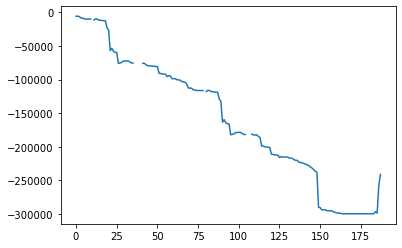

In [68]:
glr['25_from_client'].cumsum().plot()

<AxesSubplot:>

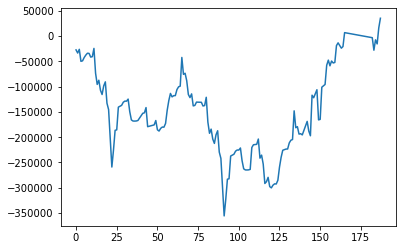

In [85]:
glr[glr['14limit0.02_from_client'] > -150000]['14limit0.02_from_client'].cumsum().plot()

<AxesSubplot:>

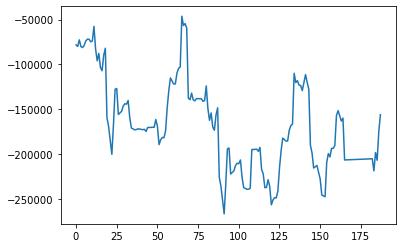

In [86]:
glr[glr['7limit0.02_from_client'] > -150000]['7limit0.02_from_client'].cumsum().plot()

In [72]:
glr

,1/2 tod limit,tod limit,1/2 tom limit,tom limit,25%,20%,15%,10%,5%,vwap tod+tom,...,hold14_from_client,hold28_from_client,7limit0.03_from_client,7limit0.02_from_client,7limit0.01_from_client,7limit0_from_client,14limit0.03_from_client,14limit0.02_from_client,14limit0.01_from_client,14limit0_from_client
0,39.150000,0.0,39.700000,0.0,38.834028,38.839674,38.889035,38.924798,39.196652,39.909514,...,-31500.000000,-74250.000000,-78250.000000,-78250.000000,-78250.000000,-78250.000000,-27250.000000,-27250.000000,-27250.000000,-27250.000000
1,1.750556,0.0,1.750000,0.0,1.755223,1.755223,1.755223,1.755223,1.755223,1.757770,...,350.000000,350.000000,-1750.000000,-1750.000000,-1750.000000,-0.000000,-6183.333333,-6183.333333,-6183.333333,-0.000000
2,544.604687,0.0,545.300000,0.0,546.139000,545.993421,545.961786,546.085556,546.134463,550.419719,...,7333.333333,7333.333333,11800.000000,7333.333333,7333.333333,-0.000000,11800.000000,7333.333333,7333.333333,-0.000000
3,42.150000,0.0,42.330000,0.0,42.361630,42.332799,42.319422,42.325067,42.276593,42.220120,...,-17400.000000,-32333.333333,-7444.444444,-7444.444444,-7444.444444,-7444.444444,-23755.555556,-23755.555556,-23755.555556,-23755.555556
4,55.560000,0.0,56.260000,0.0,54.856867,54.904698,54.965625,55.140077,55.529397,56.345062,...,-832.000000,942.933333,-1141.688889,-1141.688889,-1141.688889,-1141.688889,36.977778,942.933333,942.933333,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,6102.766473,0.0,6146.085817,0.0,6097.370066,6097.111111,6097.129360,6098.185567,6097.308125,6128.240633,...,4666.666667,4666.666667,-13533.333333,-13533.333333,10933.333333,0.000000,-24777.777778,-24777.777778,10933.333333,0.000000
184,191.459583,0.0,190.861382,0.0,191.113393,190.921575,191.072720,191.122000,191.122000,191.164484,...,3500.000000,3500.000000,32500.000000,20500.000000,20500.000000,-0.000000,32500.000000,20500.000000,20500.000000,-0.000000
185,2.065000,0.0,2.065000,0.0,2.067024,2.067024,2.067024,2.067024,2.067024,2.072687,...,-8400.000000,1200.000000,-8625.000000,-8625.000000,-8625.000000,-8625.000000,-8050.000000,-8050.000000,-8050.000000,-8050.000000
186,6148.135475,0.0,6020.454570,0.0,6174.587209,6175.070455,6174.694030,6171.227848,6153.103041,6044.715615,...,31800.000000,31800.000000,41200.000000,31800.000000,31800.000000,0.000000,41200.000000,31800.000000,31800.000000,0.000000


<AxesSubplot:>

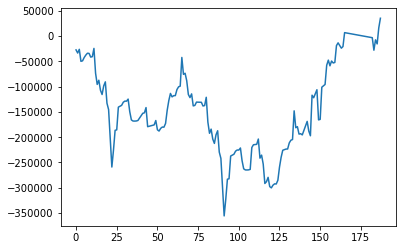

In [70]:
glr['14limit0.02_from_client'].cumsum().plot()

In [47]:
glr.sum()

1/2 tod limit                                                             238729
tod limit                                                                7.93849
1/2 tom limit                                                             238926
tom limit                                                                724.805
25%                                                                       221082
20%                                                                       221080
15%                                                                       221061
10%                                                                       221009
5%                                                                        227218
vwap tod+tom                                                              238847
vwap tom                                                                  161172
vwap tod                                                                  160810
tod auc                     